In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio

import torch
from torch.utils.data import DataLoader
from torchvision import io, datasets, transforms

In [2]:
print(f"Using v{torch.__version__}")
print(torch.__config__.show())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

Using v1.13.1+cu117
PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86
  - CuDNN 8.5
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -fabi-version=11 -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEB

In [3]:
DATASET = pathlib.Path("/media/sambhav/30AC4696AC46568E/datasets/inaria")
TRAIN_IMAGES = DATASET / "train" / "images"
TRAIN_maskS = DATASET / "train" / "gt"
#TEST_IMAGES = DATASET / "test" / "images"

In [4]:
class InariaDataset(datasets.VisionDataset):
    def __init__(self, dataset_path, split = "train", image_size = 224, transforms = None):
        #super().__init__(dataset_path, transforms)

        self.root = dataset_path
        
        assert split in {"train", "test", "pretrain"}
        self.split = split

        self.transforms = transforms
        self.image_size = image_size

        self.data, self.targets = self._get_file_paths()
   
    def _get_test_file_names(self) -> set:
        locations = ["austin", "chicago", "kitsap", "tyrol-w", "vienna"]
        test_file_names = set() 
        for location in locations:
            for idx in range(1, 6):
                test_file_names.add(f"{location}{idx}.tif")
        return test_file_names

    def _get_train_file_names(self) -> set:
        train_images_dir = self.root / "train" / "images"
        return {x.as_posix().split("/")[-1] for x in train_images_dir.iterdir()} - self._get_test_file_names()

    def _get_pretrain_file_names(self) -> set:
        pretrain_images_dir = self.root / "test" / "images"
        return [x.as_posix() for x in pretrain_images_dir.iterdir()]
    
    def _get_file_paths(self):
        if self.split == "train":
            filenames = self._get_train_file_names()
        elif self.split == "test":
            filenames = self._get_test_file_names()
        elif self.split == "pretrain":
            return (self._get_pretrain_file_names(), None)

        data_paths = list()
        mask_paths = list()
        for filename in filenames:
            image_path = self.root / "train" / "images" / filename
            data_paths.append(image_path.as_posix())
            
            mask_path = self.root / "train" / "gt" / filename
            mask_paths.append(mask_path.as_posix())

        return (data_paths, mask_paths)

    def _load_raster_as_tensor(self, file_path, crop_params):
        with rasterio.open(file_path) as raster:
            window = rasterio.windows.Window(*crop_params)
            raster_file =  torch.from_numpy(raster.read(window = window))
        return raster_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        crop_params = (np.random.randint(0, 5000-self.image_size),
                       np.random.randint(0, 5000-self.image_size),
                       self.image_size,
                       self.image_size)

        image_file = self.data[idx]
        image = self._load_raster_as_tensor(image_file, crop_params).to(torch.float) / 255
        if self.split == "pretrain":
            return image

        mask_file = self.targets[idx]
        mask = self._load_raster_as_tensor(mask_file, crop_params).clip(0, 1)

        return (image, mask)

In [5]:
dataset = InariaDataset(DATASET, split='train', image_size=224)

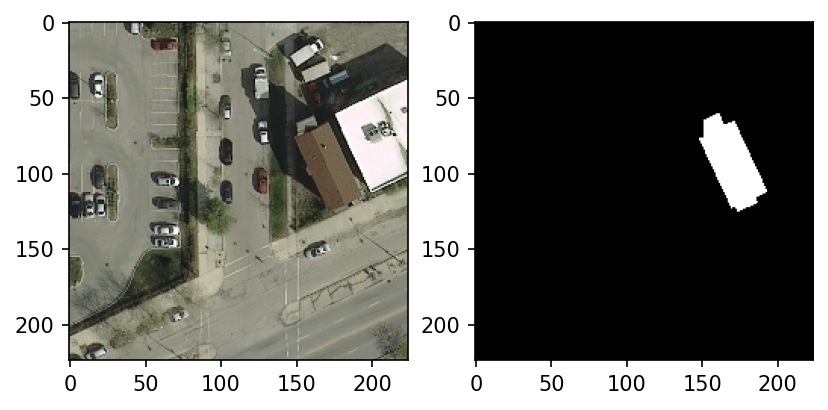

In [13]:
img, mask = dataset.__getitem__(4)
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_dpi(150)

#ax1.axis('off')
ax1.imshow(img.permute(1, 2, 0))

#ax2.axis('off')
ax2.imshow(mask.squeeze(), cmap = 'gray')